In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow


In [2]:
import os
import h5py
import math
import scipy
import numpy as np
from stl import mesh
import mahotas as mh
from skimage import measure

NEURON_ID = 3036
X_SHAPE=1024
Y_SHAPE=1024
Z_SHAPE = (0,75)
SPLINE_RESOLUTION = 1/16.
OUT_FOLDER = '/tmp/'
DATA = '/home/d/data/ac3x75/mojo/ids/tiles/w=00000000/'

def threshold(arr, val):
    out = np.zeros((arr.shape[0], arr.shape[1]), dtype=np.bool)
    out[arr == val] = 1
    return out


thresholded_3d = np.zeros((Z_SHAPE[1], Y_SHAPE, X_SHAPE), dtype=np.bool)

for SLICE in range(Z_SHAPE[0], Z_SHAPE[1]):

    img = np.zeros((Y_SHAPE,X_SHAPE), dtype=np.uint64)
    tiles = sorted(os.listdir(os.path.join(DATA, 'z='+str(SLICE).zfill(8))))


    for t in tiles:

        if t.startswith('.'):
            continue

        filepath = os.path.join(DATA, 'z='+str(SLICE).zfill(8), t)
        y = int(t.split(',')[0].split('=')[1])
        x = int(t.split(',')[1].split('=')[1].split('.')[0])
        with h5py.File(filepath, 'r') as f:
            data = f.get('IdMap')
            img[y*512:y*512+512, x*512:x*512+512] = data

    # now threshold this bad boy
    thresholded_slice = threshold(img, NEURON_ID)
    thresholded_3d[SLICE] = thresholded_slice
    
upsampled = thresholded_3d.repeat(10, axis=0)
volume = upsampled.swapaxes(0,1)

In [3]:
class Edger:
    def __init__(self, spots):

        # Generate edge_image output and edges input 
        self.edge_image = np.zeros(spots.shape,dtype=int)
        self.max_shape = np.array(self.edge_image.shape)-1
        self.edges = measure.find_contours(spots, 0)
        self.edges.sort(self.sortAll)

    def run(self, edgen, old_interp):
        y,x = zip(*edgen)
        # get the cumulative distance along the contour
        dist = np.sqrt((np.diff(x))**2 + (np.diff(y))**2).cumsum()[-1]
        # build a spline representation of the contour
        spline, u = scipy.interpolate.splprep([x, y])
        res =  int(SPLINE_RESOLUTION * dist)
        sampler = np.linspace(0, u[-1], res)

        # resample it at smaller distance intervals
        interp_x, interp_y = scipy.interpolate.splev(sampler, spline)
        iy,ix = [[int(math.floor(ii)) for ii in i] for i in [interp_x,interp_y]]
        interp = [np.clip(point,[0,0],self.max_shape) for point in zip(ix,iy)]

        for j in range(1, len(interp)):
            mh.polygon.line(interp[j-1], interp[j], self.edge_image)
        
        # Return spline for next slice
        print old_interp
        return interp

    def sortAll(self,a,b):
        xylists = [zip(*a),zip(*b)]
        da,db = [np.array([max(v)-min(v) for v in l]) for l in xylists]
        return 2*int((da-db < 0).all())-1

    def runAll(self,old_interp):
        self.run(self.edges[0], old_interp)

class Mesher:
    old_interp = []
    def __init__(self,volume):
        self.volume = volume
        self.slice_run = range(self.volume.shape[0])
        self.edge_vol = np.zeros(volume.shape)        
        self.runAll()
    def run(self,k):
        edgy = Edger(self.volume[k])
        self.old_interp = edgy.runAll(self.old_interp)
        self.edge_vol[k] = edgy.edge_image
        print 'k ',k
    def runAll(self):
#         self.run(21)
#         self.run(22)
#         return 0
        for sli in self.slice_run:
            self.run(sli)

In [129]:
def store_mesh(arr, filename):

    verts, faces = measure.marching_cubes(arr, 0, spacing=(1.,1.,1.),gradient_direction='ascent')
    applied_verts = verts[faces]

    mesh_data = np.zeros(applied_verts.shape[0], dtype=mesh.Mesh.dtype)

    for i, v in enumerate(applied_verts):
        mesh_data[i][1][0] = v[0]
        mesh_data[i][1][1] = v[1]
        mesh_data[i][1][2] = v[2]

    m = mesh.Mesh(mesh_data)
    with open(filename, 'w') as f:
        m.save(filename, f)

    return m

# m1 = store_mesh(meshed, OUT_FOLDER+str(NEURON_ID)+'_smooth.stl')

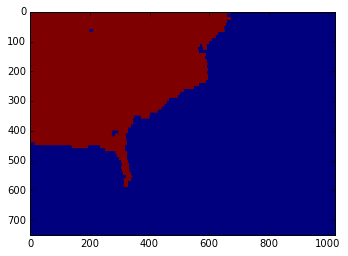

In [9]:
imshow(volume[0])

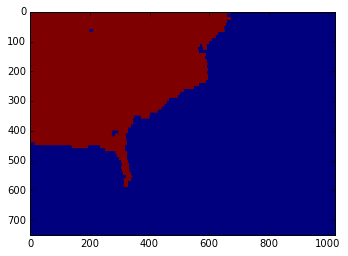

In [10]:
imshow(volume[1])

In [81]:
m = Mesher(volume)

[]
k  0
None
k  1
None
k  2
None
k  3
None
k  4
None
k  5
None
k  6
None
k  7
None
k  8
None
k  9
None
k  10
None
k  11
None
k  12
None
k  13
None
k  14
None
k  15
None
k  16
None
k  17
None
k  18
None
k  19
None
k  20
None
k  21
None
k  22
None
k  23
None
k  24
None
k  25
None
k  26
None
k  27
None
k  28
None
k  29
None
k  30
None
k  31
None
k  32
None
k  33
None
k  34
None
k  35
None
k  36
None
k  37
None
k  38
None
k  39
None
k  40
None
k  41
None
k  42
None
k  43
None
k  44
None
k  45
None
k  46
None
k  47
None
k  48
None
k  49
None
k  50
None
k  51
None
k  52
None
k  53
None
k  54
None
k  55
None
k  56
None
k  57
None
k  58
None
k  59
None
k  60
None
k  61
None
k  62
None
k  63
None
k  64
None
k  65
None
k  66
None
k  67
None
k  68
None
k  69
None
k  70
None
k  71
None
k  72
None
k  73
None
k  74
None
k  75
None
k  76
None
k  77
None
k  78
None
k  79
None
k  80
None
k  81
None
k  82
None
k  83
None
k  84
None
k  85
None
k  86
None
k  87
None
k  88
None
k  89
None
k  90
None
k  91


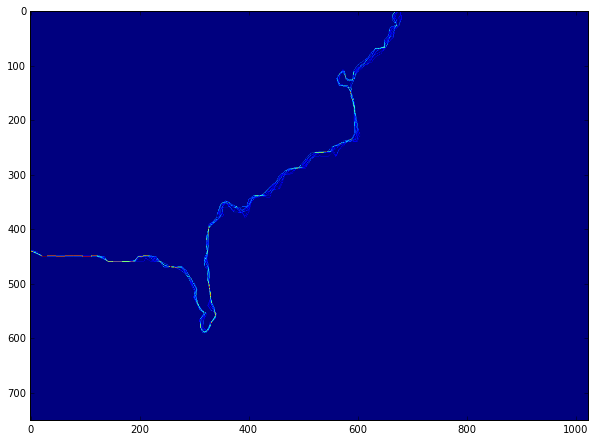

In [23]:
edge_sum = np.sum(m.edge_vol, axis=0)

imshow(edge_sum)

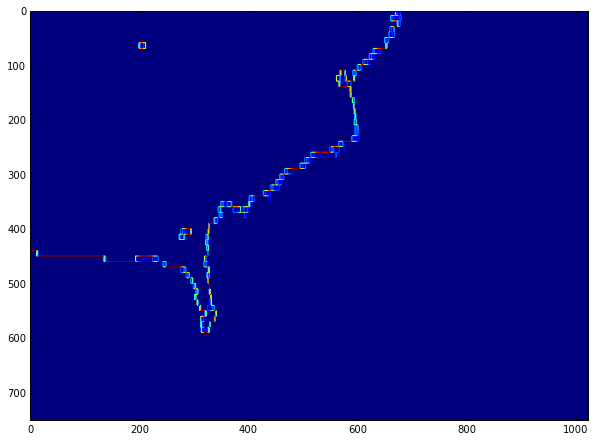

In [25]:
orig_borders = np.copy(m.edge_vol)
orig_borders[:] = 0

for z in range(orig_borders.shape[0]):
    orig_borders[z] = mh.labeled.borders(volume[z])

edge_sum2 = np.sum(orig_borders, axis=0)

imshow(edge_sum2)

In [58]:
import skimage.measure
def normalize_labels(array):
    '''
    '''
    return mh.labeled.relabel(array)

def relabel(array):

    relabeled_array = np.array(array)
  
    relabeled_array = skimage.measure.label(array, background=-1).astype(np.uint64)
    # relabeled_array[relabeled_array==0] = relabeled_array.max()
    
    return normalize_labels(relabeled_array)[0]

In [220]:
solid_vol2 = m.edge_vol.astype(np.bool).copy()

solid_vol2[:] = 0

for z in range(m.edge_vol.shape[0]):
# for z in range(0,200):#174,175):
# for z in range(184,185):


    first = m.edge_vol[z].copy()

    dilated = mh.dilate(first.astype(np.bool))
    dilated = mh.close_holes(dilated)
  
    relabeled = relabel(dilated)

    dilate_counter = 1
    
    while relabeled.max() < 3:
        dilated = mh.dilate(dilated)
        relabeled = relabel(dilated)
        dilate_counter += 1
#     if dilate_counter!=1:
#     print z, dilate_counter
    
#     if relabeled.min() != 0:
#         print 'HERE', z
    
    
    
    center = mh.center_of_mass(m.volume[z])

    good_value = relabeled[center[0], center[1]]
    relabeled[relabeled!=good_value] = 0
    relabeled[dilated==1] = good_value


    
    
#     closed_first = dilated.copy()
#     for z in range(dilate_counter):
#         closed_first = mh.erode(closed_first)    
    
    solid_vol2[z] = relabeled.astype(np.bool)
    


/home/d/nolearn/lib/python2.7/site-packages/ipykernel/__main__.py:33: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [221]:
store_mesh(solid_vol, '/tmp/outnew3.stl')

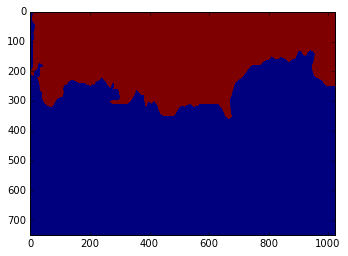

In [217]:
imshow(solid_vol2[184])

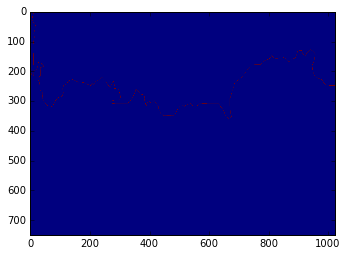

In [213]:
imshow(first)

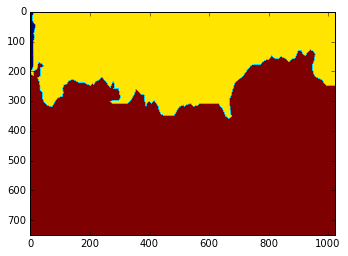

In [215]:
imshow(relabel(mh.dilate(first.astype(np.bool))))

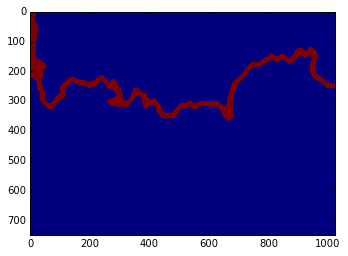

In [211]:
a = dilated.copy()
for i in range(dilate_counter/2):
    a = mh.erode(a)
imshow(a)

/home/d/nolearn/lib/python2.7/site-packages/ipykernel/__main__.py:1: DeprecationWarning: numpy boolean subtract, the `-` operator, is deprecated, use the bitwise_xor, the `^` operator, or the logical_xor function instead.
  if __name__ == '__main__':


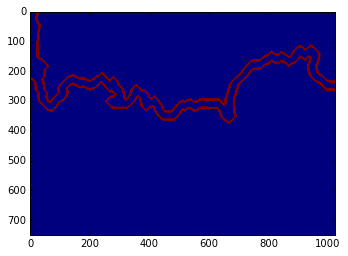

In [212]:
imshow(dilated-a)

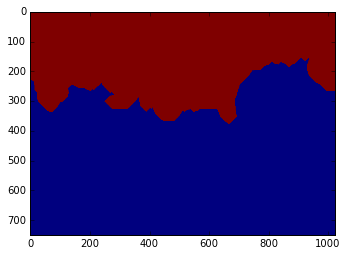

In [187]:
imshow(solid_vol2[184])

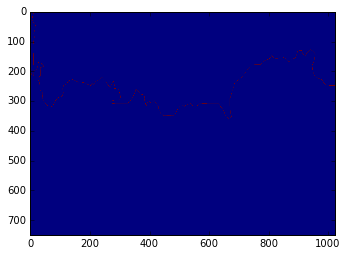

In [188]:
imshow(first)

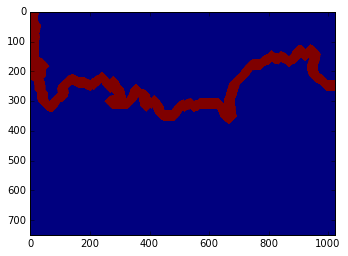

In [189]:
imshow(dilated)

In [190]:
a = solid_vol2[184].copy()


In [191]:
dilate_counter

18

In [193]:
for i in range(dilate_counter):
    a = mh.erode(a)

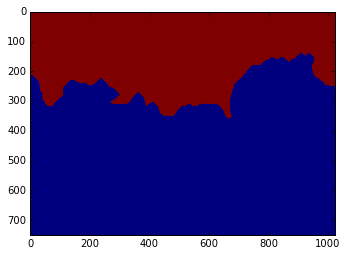

In [194]:
imshow(a)

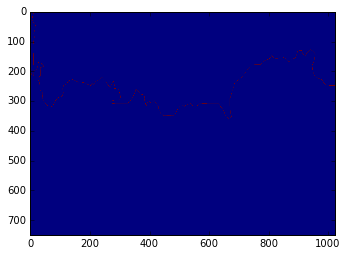

In [195]:
imshow(first)

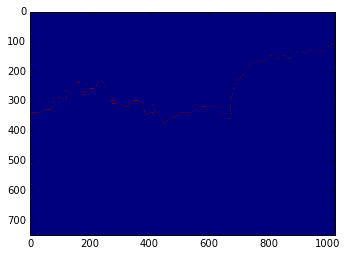

In [173]:
imshow(dilated)

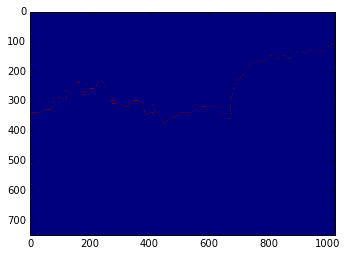

In [174]:
imshow(relabel(dilated))

In [204]:
a = np.zeros((7000,5664,5664), dtype=np.bool)

MemoryError: 